# Stage 2: Wound Type Classification - Testing & Verification

This notebook verifies the trained Stage 2 model (`best_model.pth`) on sample images from the dataset.

**Objective**: Confirm the model correctly classifies different wound types:
- Abrasion
- Bruise
- Burn
- Cut
- Diabetic Foot
- Laceration
- Surgical

In [1]:
import os
import sys
import torch
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob

# Project Root
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# Config
MODEL_PATH = PROJECT_ROOT / "models" / "stage2_type" / "best_model.pth"
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "type_classification"
CLASSES = ['abrasion', 'bruise', 'burn', 'cut', 'diabetic_foot', 'laceration', 'surgical']
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")
print(f"Model Path: {MODEL_PATH}")

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Model Path: F:\Housepital-AI\Housepital-AI\AI_Pipeline_V2\models\stage2_type\best_model.pth


## 1. Load Model

In [2]:
def load_model(path, num_classes):
    model = timm.create_model('tf_efficientnet_b0', pretrained=False, num_classes=num_classes)
    checkpoint = torch.load(path, map_location=DEVICE)
    
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.to(DEVICE)
    model.eval()
    return model

try:
    model = load_model(MODEL_PATH, len(CLASSES))
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load model: {e}")

✅ Model loaded successfully.


## 2. Prediction Helper

In [3]:
# Transform (Preprocessing)
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def predict_image(model, image_path):
    # Load Image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Preprocess
    augmented = transform(image=image_np)
    img_tensor = augmented['image'].unsqueeze(0).to(DEVICE)
    
    # Inference
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0]
        
    # Top Prediction
    top_prob, top_idx = torch.max(probs, dim=0)
    top_class = CLASSES[top_idx.item()]
    
    return top_class, top_prob.item(), image

def show_prediction(path):
    pred_class, conf, img = predict_image(model, path)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {pred_class} ({conf:.1%})")
    plt.show()
    print(f"File: {Path(path).name} | Prediction: {pred_class} | Confidence: {conf:.4f}")

## 3. Test on Samples

In [4]:
# Select 1 random image from each class folder
import random

test_images = []

for cls in CLASSES:
    folder = DATA_DIR / cls
    files = list(folder.glob("*.jpg")) + list(folder.glob("*.png"))
    if files:
        chosen = random.choice(files)
        test_images.append((cls, chosen))
    else:
        print(f"Warning: No images found for {cls}")

print(f"Found {len(test_images)} test images.")

Found 7 test images.


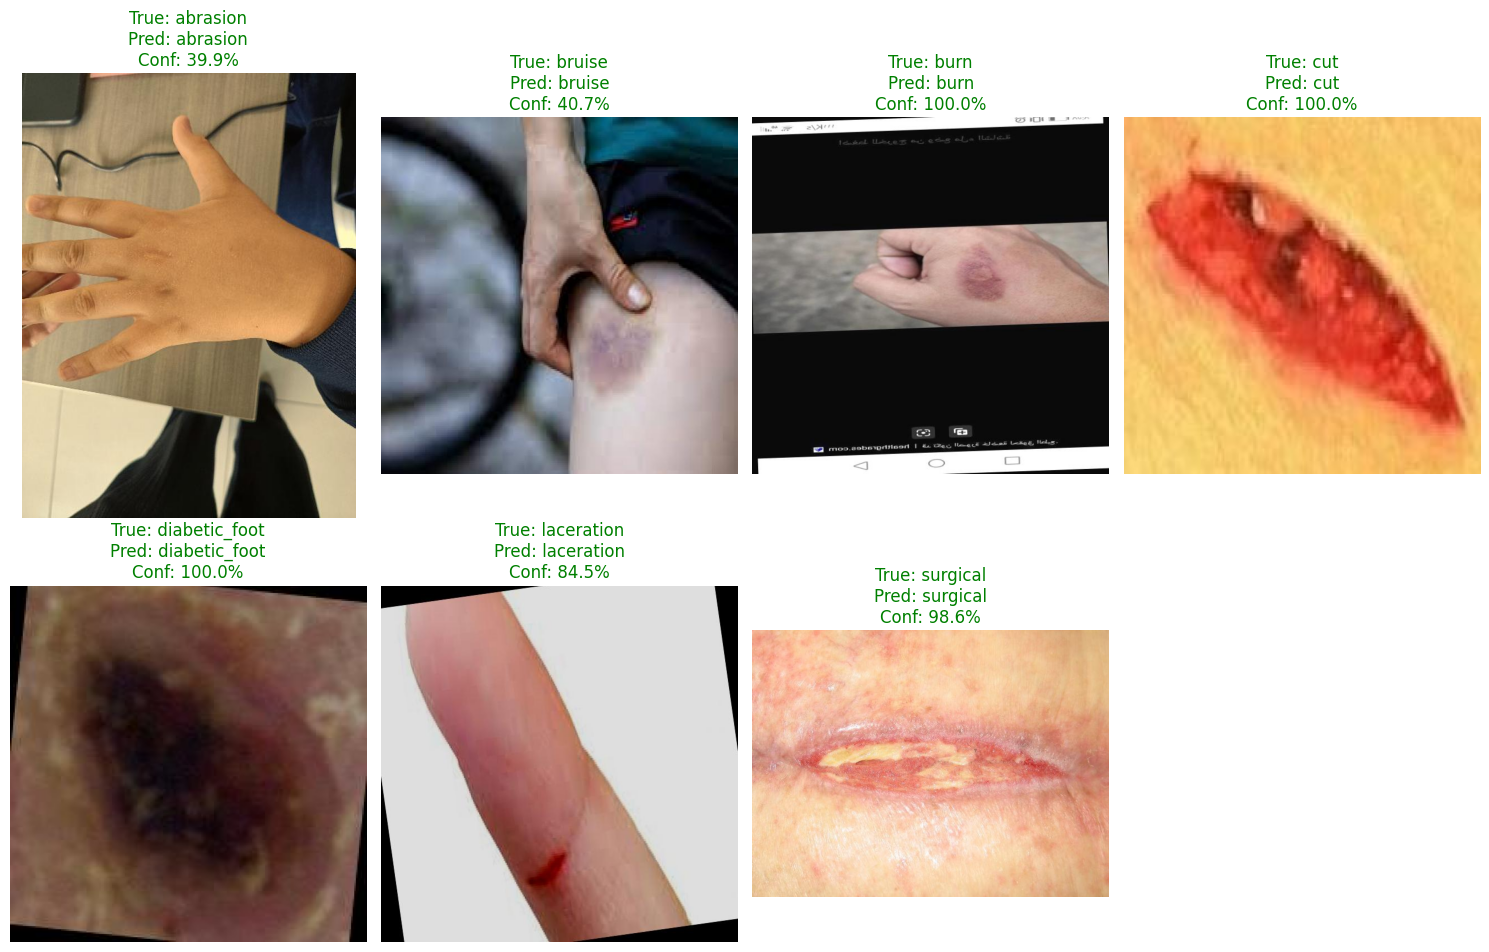

In [5]:
# Visualize Results
plt.figure(figsize=(15, 10))

for i, (true_cls, path) in enumerate(test_images):
    pred_class, conf, img = predict_image(model, path)
    
    ax = plt.subplot(2, 4, i + 1)
    ax.imshow(img)
    ax.axis('off')
    
    color = 'green' if pred_class == true_cls else 'red'
    ax.set_title(f"True: {true_cls}\nPred: {pred_class}\nConf: {conf:.1%}", color=color)

plt.tight_layout()
plt.show()